<a href="https://colab.research.google.com/github/alistair0111/TensorFlow-In-Practice/blob/master/Natural%20Language%20Processing%20in%20TensorFlow/Course_3_Week_3_Lesson_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.2.0


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2KXC66/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2KXC66/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2KXC66/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [0]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 17s 22ms/step - loss: 0.5185 - accuracy: 0.7185 - val_loss: 0.3602 - val_accuracy: 0.8424
Epoch 2/50
782/782 [==============================] - 16s 21ms/step - loss: 0.2982 - accuracy: 0.8767 - val_loss: 0.3511 - val_accuracy: 0.8505
Epoch 3/50
782/782 [==============================] - 17s 21ms/step - loss: 0.2286 - accuracy: 0.9128 - val_loss: 0.3767 - val_accuracy: 0.8400
Epoch 4/50
782/782 [==============================] - 16s 21ms/step - loss: 0.1712 - accuracy: 0.9376 - val_loss: 0.4192 - val_accuracy: 0.8382
Epoch 5/50
782/782 [==============================] - 16s 21ms/step - loss: 0.1185 - accuracy: 0.9602 - val_loss: 0.5650 - val_accuracy: 0.8222
Epoch 6/50
782/782 [==============================] - 16s 21ms/step - loss: 0.0766 - accuracy: 0.9740 - val_loss: 0.5645 - val_accuracy: 0.8183
Epoch 7/50
782/782 [==============================] - 17s 21ms/step - loss: 0.0465 - accuracy: 0.9853 - val_loss: 0.7485 - val_accuracy:

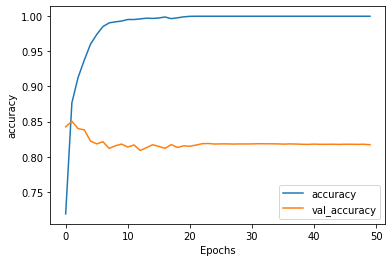

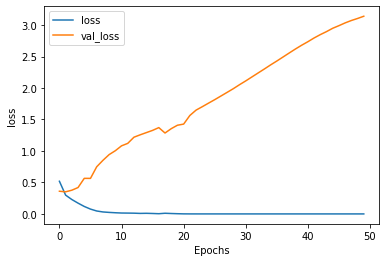

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [10]:
# Model Definition with LSTM
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()
num_epochs = 50
history = model1.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 18s 23ms/step - loss: 0.4942 - accuracy: 0.7466 - val_loss: 0.3565 - val_accuracy: 0.8461
Epoch 2/50
782/782 [==============================] - 17s 22ms/step - loss: 0.3017 - accuracy: 0.8776 

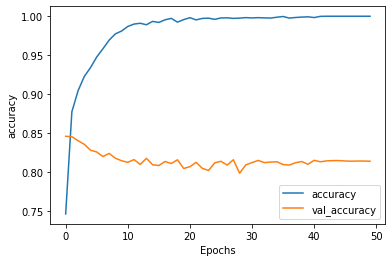

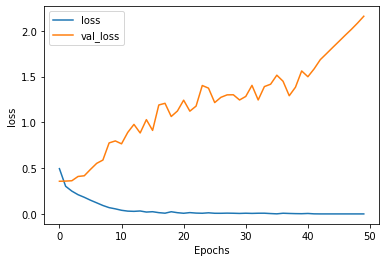

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [12]:
# Model Definition with Conv1D
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()
num_epochs = 50
history = model1.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 17s 22ms/step - loss: 1.4194e-06 - accuracy: 1.0000 - val_lo

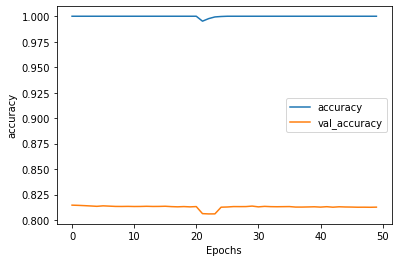

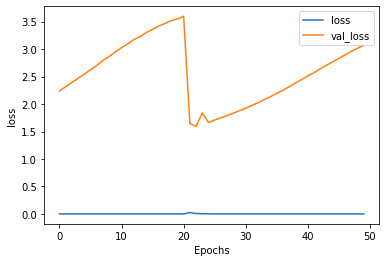

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')